# Setup

## Imports

In [98]:
# Setup
import os
import joblib
import pickle
import json
from utils.custom_transformers import ColumnSelector, CategoricalTransformer, SaveTransformer, NumericalTransformer
from collections import Counter

# Data Analysis
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sn

#Scikit learn
from lightgbm import LGBMClassifier
from category_encoders import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, auc, roc_curve, precision_recall_curve, precision_score, accuracy_score, precision_recall_fscore_support, auc, recall_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay

#Model tuning
from sklego.meta import Thresholder
from yellowbrick.classifier import DiscriminationThreshold


## Configs

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
seed = 42

## Functions

In [3]:
def load_data(file_name, folder = "data"):
    df = pd.read_csv(os.path.join(folder, file_name))
    return df

def target_transformation(text):
    text = text.replace(" ", "").lower()
    if text == "yes" :
        return 1
    elif text == "no":
        return 0

# Data Analysis

## Data Load

In [4]:
df_original = load_data("train_data.csv","data")

In [5]:
patient_list = set(df_original['patient_id'])
patients_to_remove = []
for patient_id in patient_list:
    data = df_original[df_original['patient_id']==patient_id]
    distinct_gender = data['gender'].nunique()
    distinct_blood_type = data['blood_type'].nunique()
    if distinct_gender > 1 or distinct_blood_type > 1:
        patients_to_remove.append(patient_id)
        
df_original_filtered = df_original.copy()
df_original_filtered = df_original_filtered.loc[~df_original_filtered['patient_id'].isin(patients_to_remove)]

# Pipelines

## Custom Transformers

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_original_filtered.drop(columns=['readmitted']), 
                                                    df_original_filtered['readmitted'],
                                                    shuffle = True,
                                                    test_size=0.4,
                                                    stratify = df_original_filtered['readmitted'], 
                                                    random_state=seed)
y_train = y_train.apply(target_transformation)
y_test = y_test.apply(target_transformation)

In [89]:
def result_metrics(y_test, y_test_pred, y_test_proba):

    precision_s = precision_score (y_test,y_test_pred )
    accuracy_s = accuracy_score (y_test,y_test_pred )
    recall_s = recall_score (y_test,y_test_pred )
    roc_auc_s = roc_auc_score(y_test,y_test_pred )
    f1_s = f1_score(y_test,y_test_pred )

    print(
    """Key Metrics:

    Precision : {} 
    Accuracy: {}  
    Recall: {} 
    ROC-AUC: {}
    F1 Score: {}""".format(round(precision_s,3),round(accuracy_s,3) ,round(recall_s,3) ,round(roc_auc_s,3),round(f1_s,3) ))

    
    print("""
    
    --------
    Confusion Matrix
    
    """)
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    plt.show()
    
    print("""
    -------------

    Recall vs Precision Tresholds:
    """)
    results = []
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
    precision = precision[:-1]
    recall = recall[:-1]
    results_df = { "thresholds": thresholds, "precision": precision, "recall": recall}
    results_df = pd.DataFrame(results_df)
    results_df['f1_score'] = 2*((results_df['precision']*results_df['recall'])/(results_df['precision']+results_df['recall']))
    fig=plt.figure()
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
    ax1.plot(thresholds,precision)
    ax2.plot(thresholds,recall)
    ax1.get_shared_x_axes().join(ax1, ax2)
    ax1.set_xticklabels([])
    plt.xlabel('Threshold')
    ax1.set_title('Precision')
    ax2.set_title('Recall')
    plt.show()
    
    print ("""

    --------

    ROC-AUC Curve:
    """)

    fpr, tpr, threshold = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    plt.title("Receiver Operating Characteristic")
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    min_index = [i for i, f1s in enumerate(results_df['f1_score']) if f1s >= max(results_df['f1_score'])][0]
    f1_score_tresh = 2*((precision[min_index]*recall[min_index])/(precision[min_index]+recall[min_index]))
    
    print ("""

    --------

    Results for optimized threshold:
    Threshold : {}
    Precision: {}
    Recall: {}
    F1_Score: {}
    """.format(round(results_df['thresholds'][min_index],3), round(results_df['precision'][min_index],3), round(results_df['recall'][min_index],3), round(results_df['f1_score'][min_index],3)))
    y_test_proba_pred = [1 if x >= results_df['thresholds'][min_index] else 0 for x in y_test_proba]
    print("""
    
    --------
    Confusion Matrix on thresholds:
    
    """)
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_proba_pred)
    plt.show()

In [103]:
def run_pipeline(X_train, y_train, X_test, categorical, numerical, estimator):

    cat_pipe = Pipeline([
        ('selector', ColumnSelector(categorical))
        ,('transformer',CategoricalTransformer(mininum_records = 250))
        ,('imputer', SimpleImputer(missing_values = None, strategy='constant', fill_value='missing'))
        ,('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    num_pipe = Pipeline([
        ('selector', ColumnSelector(numerical))
        ,('transformer',NumericalTransformer())
        ,('imputer', SimpleImputer(strategy='median'))
        ,('scaler', RobustScaler())
    ])

    pre_processor = FeatureUnion([
        ('cat', cat_pipe)
        ,('num', num_pipe)
    ])

    pipeline = Pipeline([
        ('preprocessor', pre_processor)
        ,('model',estimator )
    ])

    pipeline.fit(X_train, y_train)

    y_test_pred = pipeline.predict(X_test)
    y_test_proba = pipeline.predict_proba(X_test)[:,1]

    return y_test_pred, y_test_proba

In [109]:
def test_pipelines(X_train, y_train, X_test, pipelines):
    for pipeline in pipelines:
        df = pipeline['data']
        X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['readmitted']), 
                                                    df['readmitted'],
                                                    shuffle = True,
                                                    test_size=0.3,
                                                    stratify = df['readmitted'], 
                                                    random_state=seed)
        y_train = y_train.apply(target_transformation)
        y_test = y_test.apply(target_transformation)        
        y_test_pred, y_test_proba = run_pipeline(X_train, y_train, X_test, pipeline['categorical'], pipeline['numerical'], pipeline['estimator'])
        print("Pipeline :{}".format(pipeline['id']))
        result_metrics(y_test, y_test_pred, y_test_proba)
        

In [110]:
pipeline_1 = {
    'id':1
    ,'data': df_original
    ,'estimator': GradientBoostingClassifier(random_state=seed)
    ,'categorical':['diag_2','diag_3','weight','race','admission_source_code','discharge_disposition_code','admission_type_code','medical_specialty','insulin','change','gender','diag_1','A1Cresult','max_glu_serum','diabetesMed','has_prosthesis','blood_transfusion','diuretics','payer_code','complete_vaccination_status','blood_type','age']
    ,'numerical': ['num_medications','hemoglobin_level','time_in_hospital','num_lab_procedures','num_procedures','number_outpatient','number_emergency','number_inpatient','number_diagnoses']}

pipeline_2 = {
    'id':2 
    ,'data': df_original
    ,'estimator': GradientBoostingClassifier(random_state=seed)
    ,'categorical':['diabetesMed','blood_transfusion','admission_source_code','discharge_disposition_code','admission_type_code','payer_code','complete_vaccination_status','blood_type','max_glu_serum','A1Cresult','age','gender','medical_specialty', 'diag_1']
    ,'numerical': ['time_in_hospital','num_lab_procedures','num_procedures','number_outpatient','number_emergency','number_inpatient','number_diagnoses','hemoglobin_level']}

pipeline_3 = {
    'id':3 
    ,'data': df_original
    ,'estimator': GradientBoostingClassifier(random_state=seed)
    ,'categorical':['diabetesMed','blood_transfusion','admission_source_code','discharge_disposition_code','admission_type_code','payer_code','complete_vaccination_status','max_glu_serum','A1Cresult','age','gender','medical_specialty', 'diag_1']
    ,'numerical': ['time_in_hospital','num_lab_procedures','num_procedures','number_outpatient','number_emergency','number_inpatient','number_diagnoses','hemoglobin_level']}

pipeline_4 = {
    'id':4 
    ,'data': df_original_filtered
    ,'estimator': GradientBoostingClassifier(random_state=seed)
    ,'categorical':['diabetesMed','blood_transfusion','admission_source_code','discharge_disposition_code','admission_type_code','payer_code','complete_vaccination_status','blood_type','max_glu_serum','A1Cresult','age','gender','medical_specialty', 'diag_1']
    ,'numerical': ['time_in_hospital','num_lab_procedures','num_procedures','number_outpatient','number_emergency','number_inpatient','number_diagnoses','hemoglobin_level']}

pipeline_5 = {
    'id':5 
    ,'data': df_original_filtered
    ,'estimator': GradientBoostingClassifier(random_state=seed)
    ,'categorical':['diabetesMed','blood_transfusion','admission_source_code','discharge_disposition_code','admission_type_code','payer_code','complete_vaccination_status','max_glu_serum','A1Cresult','age','gender','medical_specialty', 'diag_1']
    ,'numerical': ['time_in_hospital','num_lab_procedures','num_procedures','number_outpatient','number_emergency','number_inpatient','number_diagnoses','hemoglobin_level']}

pipelines = [pipeline_2, pipeline_3, pipeline_4, pipeline_5]
#Best in Pipeline 2

Pipeline :2
Key Metrics:

    Precision : 0.533 
    Accuracy: 0.889  
    Recall: 0.009 
    ROC-AUC: 0.504
    F1 Score: 0.017

    
    --------
    Confusion Matrix
    
    


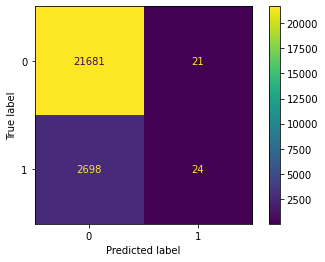


    -------------

    Recall vs Precision Tresholds:
    


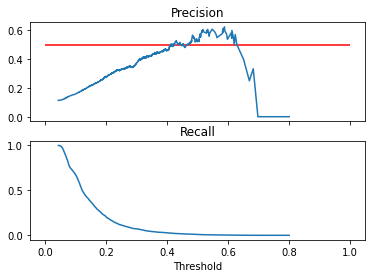



    --------

    ROC-AUC Curve:
    


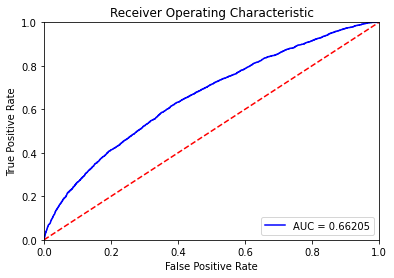



    --------

    Results for optimized threshold:
    Threshold : 0.142
    Precision: 0.209
    Recall: 0.406
    F1_Score: 0.276
    

    
    --------
    Confusion Matrix on thresholds:
    
    


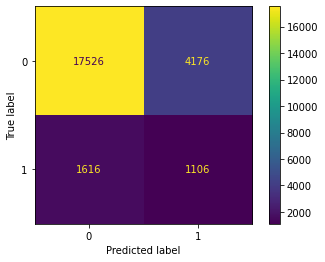

Pipeline :3
Key Metrics:

    Precision : 0.5 
    Accuracy: 0.889  
    Recall: 0.008 
    ROC-AUC: 0.504
    F1 Score: 0.016

    
    --------
    Confusion Matrix
    
    


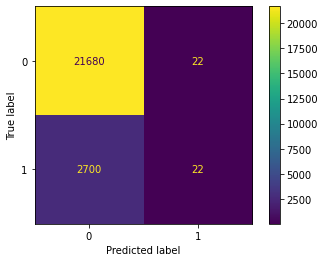


    -------------

    Recall vs Precision Tresholds:
    


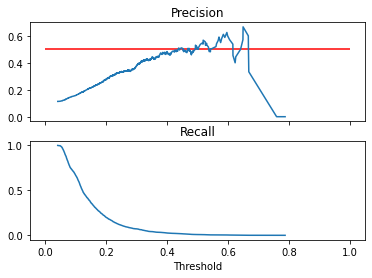



    --------

    ROC-AUC Curve:
    


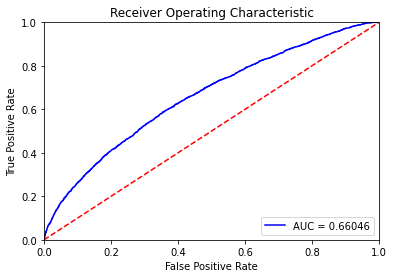



    --------

    Results for optimized threshold:
    Threshold : 0.141
    Precision: 0.208
    Recall: 0.404
    F1_Score: 0.274
    

    
    --------
    Confusion Matrix on thresholds:
    
    


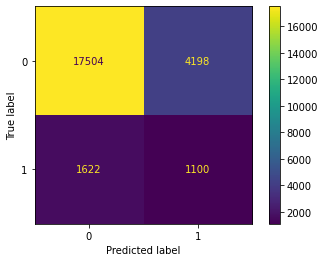

Pipeline :4
Key Metrics:

    Precision : 0.333 
    Accuracy: 0.939  
    Recall: 0.003 
    ROC-AUC: 0.501
    F1 Score: 0.006

    
    --------
    Confusion Matrix
    
    


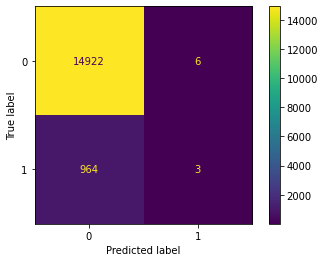


    -------------

    Recall vs Precision Tresholds:
    


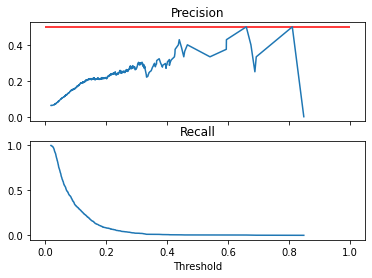



    --------

    ROC-AUC Curve:
    


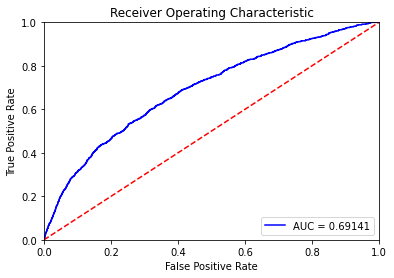



    --------

    Results for optimized threshold:
    Threshold : 0.116
    Precision: 0.187
    Recall: 0.281
    F1_Score: 0.225
    

    
    --------
    Confusion Matrix on thresholds:
    
    


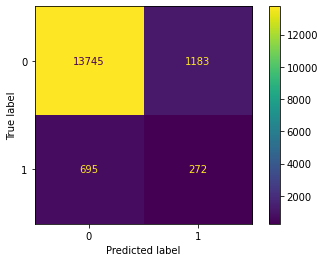

Pipeline :5
Key Metrics:

    Precision : 0.333 
    Accuracy: 0.939  
    Recall: 0.004 
    ROC-AUC: 0.502
    F1 Score: 0.008

    
    --------
    Confusion Matrix
    
    


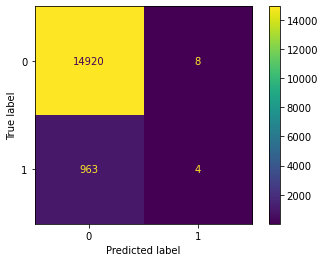


    -------------

    Recall vs Precision Tresholds:
    


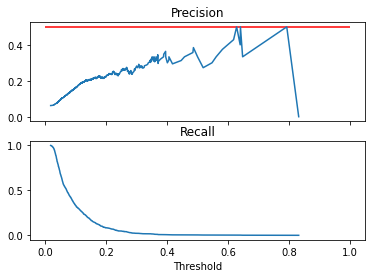



    --------

    ROC-AUC Curve:
    


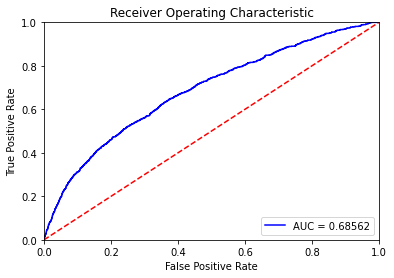



    --------

    Results for optimized threshold:
    Threshold : 0.114
    Precision: 0.184
    Recall: 0.281
    F1_Score: 0.222
    

    
    --------
    Confusion Matrix on thresholds:
    
    


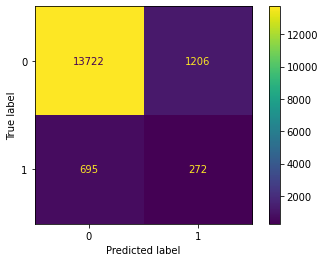

In [111]:
test_pipelines(X_train, y_train, X_test, pipelines)

# Model


In [130]:
X = df_original.drop(columns=['readmitted'])
y = df_original['readmitted']

categorical = ['diabetesMed','blood_transfusion','admission_source_code','discharge_disposition_code','admission_type_code','payer_code','complete_vaccination_status','blood_type','max_glu_serum','A1Cresult','age','gender','medical_specialty', 'diag_1']
numerical = ['time_in_hospital','num_lab_procedures','num_procedures','number_outpatient','number_emergency','number_inpatient','number_diagnoses','hemoglobin_level']
estimator = GradientBoostingClassifier(random_state=seed)

cat_pipe = Pipeline([
        ('selector', ColumnSelector(categorical))
        ,('transformer',CategoricalTransformer(mininum_records = 250))
        ,('imputer', SimpleImputer(missing_values = None, strategy='constant', fill_value='missing'))
        ,('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

num_pipe = Pipeline([
        ('selector', ColumnSelector(numerical))
        ,('transformer',NumericalTransformer())
        ,('imputer', SimpleImputer(strategy='median'))
        ,('scaler', RobustScaler())
    ])

pre_processor = FeatureUnion([
        ('cat', cat_pipe)
        ,('num', num_pipe)
    ])

pipeline = Pipeline([
        ('preprocessor', pre_processor)
        ,('model', estimator)
    ])

pipeline.fit(X,y)
#final_pipeline = make_pipeline(*pipeline[:-1], Thresholder(pipeline[1], 0.115))
#final_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('cat',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(columns=['diabetesMed',
                                                                                          'blood_transfusion',
                                                                                          'admission_source_code',
                                                                                          'discharge_disposition_code',
                                                                                          'admission_type_code',
                                                                                          'payer_code',
                                                                                          'complete_vaccination_status',
                                            

/Users/tiagosousa/projects/capstone-project/utils/custom_transformers.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return X[self.columns]


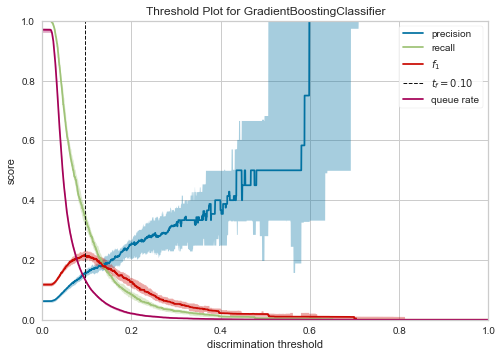

In [117]:
visualizer = DiscriminationThreshold(pipeline, quantiles=np.array([0.25, 0.5, 0.75]))

visualizer.fit(X_train, y_train)
visualizer.show();  

#best_threshold = visualizer.thresholds_[visualizer.cv_scores_[visualizer.argmax].argmax()]
final_pipeline = make_pipeline(*pipeline[:-1], Thresholder(pipeline[1], 0.115))
final_pipeline.fit(X_train, y_train);

In [123]:
dtypes_list =     {
    'readmitted':"object",
    'change':"object",
    'diabetesMed':"object",
    'has_prosthesis':"object",
    'blood_transfusion':"object",
    'diuretics':"object",
    'insulin':"object",
    'admission_source_code':"float64",
    'discharge_disposition_code':"float64",
    'admission_type_code':"float64",
    'payer_code':"object",
    'complete_vaccination_status':"object",
    'blood_type':"object",
    'max_glu_serum':"object",
    'A1Cresult':"object",
    'age':"object",
    'race':"object",
    'gender':"object",
    'diag_1':"object",
    'diag_2':"object",
    'diag_3':"object",
    'medical_specialty':"object",
    'time_in_hospital':"float64",
    'num_lab_procedures':"float64",
    'num_procedures':"float64",
    'num_medications':"float64",
    'number_outpatient':"float64",
    'number_emergency':"float64",
    'number_inpatient':"float64",
    'number_diagnoses':"float64",
    'hemoglobin_level':"float64",
    'admission_id':"int64",
    'patient_id':"int64",
    'weight':"object"
}
df_original_dtypes = df_original.astype(dtypes_list)

In [132]:
with open("columns.json", 'w') as fh:
    json.dump(df_original.columns.tolist(), fh)

with open("dtypes.pickle", 'wb') as fh:
    pickle.dump(df_original_dtypes.dtypes, fh)
    
joblib.dump(pipeline, 'pipeline.pickle') 

['pipeline.pickle']